# Part 2 of interpretability of a Convnet model


In this case the idea now is to plot what the filters see when they activate at their highest level

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

# load the 3 models we already've trained

In [ ]:
model1 = tf.keras.models.load_model("./checkpoints/model1/")

model2 = tf.keras.models.load_model("./checkpoints/model2/")

model3 = tf.keras.models.load_model("./checkpoints/model3/")

# First step build a loss function

The idea is to maximize the activation

In [ ]:
def loss(prediction):
    """
        initial_random_image: initial random image made to max out the activation of the filter.
        prediction: output of the filter's activation.
        Squared Error

        # Trying to maximize the activations average.
    """

    return tf.reduce_mean(prediction)

# Generate a random image

In [ ]:
random_initial_image = np.abs(np.random.normal(0, 1, (1, 256, 256, 3)))

In [ ]:
visual_random_initial_image = random_initial_image[0].copy()
visual_random_initial_image *=127
visual_random_initial_image = visual_random_initial_image.clip(min=0, max=255).astype("uint8")

plt.imshow(visual_random_initial_image)

# Model 1 architecture

In [ ]:
model1.summary()

It only has 2 convolution layers

The first layer has a 4 sets of 3 filters (one per channel of the input) in total 12 filters

The math goes as follow:
- 4 filters * 3x3 * 3 channels + bias = 112 parameters

We are grabing the first layer 1st_conv_3x3

In [ ]:
layer = model1.get_layer(name="1st_conv_3x3")
layer.trainable = False

# Let's inspect the layer we just extrat from the model

In [ ]:
layer.get_config()

# Going deeper we can inspect the weights

In [ ]:
kernels = layer.get_weights()[0]
bias = layer.get_weights()[1]

# Break down of what we just got here

- We have here the first 2 parameters are the kernel size h and w we are using a 3x3 kernels

- the second one is the amount of channels from the input which is 3 because we have a RGB image as input

- The last one is the output channel which is the same number as the number of filters.

- We have in total 4 set of 3 filters plus the bias learnable parameters to work with when we are training the model

In [ ]:
kernels.shape

# Inspect the values from the first channel of the first set of 3 filters out of 4.

In [ ]:
kernels[:, :, 0, 0]

# We can plot the filters directly but it won't be easy to have an interpretation

In [ ]:
filter_sample = (kernels[:, :, 0, 0]*64)+128
filter_sample = filter_sample.clip(0, 255).astype("uint8")
plt.imshow(filter_sample)

# Make a new model only with the first layer of kernels

In [ ]:
new_model1 = tf.keras.Model(inputs=model1.input, outputs=layer.output)

In [ ]:
new_model1.summary()

# We can use a custom training loop to train our model 

# Notes

Using model instead of predict allow us to get the gradient operations but this operation runs on ram it won't scale 

In [147]:
def max_out_activations(new_model, epochs, filter_index, input_shape_size, learning_rate=1e-3):

    #Creating a random image to print the filters on
    random_image = tf.random.uniform(minval=0.4, maxval=0.6, shape=input_shape_size)

    for _ in range(epochs):

        with tf.GradientTape() as tape:
            # random image is not a tf.Variable thus we need to explicity tell the gradient tape to look at it
            tape.watch(random_image)

            activation = new_model(random_image)

            activation = activation[:, 2:-2, 2:-2, filter_index]
            loss_value = loss(activation)
            #Avoid getting artifacts? what does this mean?
            #Calculate the loss
            #I want to maximize the activation thus the loss is the mean of activations
            #for all the channels of that particular filter
            # loss_value = loss(activation[:, 2:-2, 2:-2, filter_index])
            # loss_value = loss(activation[:, :, :, filter_index])

        gradients = tape.gradient(loss_value, random_image)
        gradients = tf.math.l2_normalize(gradients)
        
        # In favor of the gradient in this case I want to MAXIMIZE the loss function
        random_image += gradients*learning_rate

    return random_image.numpy()[0]

In [148]:
def preproces_img(image_output):

    filter_patern = image_output.copy()
    filter_patern -= filter_patern.mean()
    filter_patern /= filter_patern.std()
    filter_patern *= 64
    filter_patern += 128
    filter_patern = np.clip(filter_patern, 0, 255).astype("uint8")

    #Center image
    return filter_patern[25:-25, 25:-25, :]
    # return filter_patern

In [149]:
max_out_activations(new_model1, 40, 0, (1, 256, 256, 3), 10)[:, :, 0]

array([[0.4623586 , 0.40134183, 0.45852613, ..., 0.513084  , 0.58036745,
        0.4096503 ],
       [0.4427463 , 0.50754946, 0.4229343 , ..., 0.55329126, 0.53419805,
        0.5620666 ],
       [0.4536437 , 0.5156537 , 0.4054224 , ..., 0.45896184, 0.517241  ,
        0.48211172],
       ...,
       [0.54634464, 0.42225254, 0.515093  , ..., 0.28735304, 0.4048834 ,
        0.50424415],
       [0.5530675 , 0.53583336, 0.527141  , ..., 0.54254675, 0.5770611 ,
        0.59048986],
       [0.4779844 , 0.412798  , 0.594292  , ..., 0.41220507, 0.55462706,
        0.41564572]], dtype=float32)

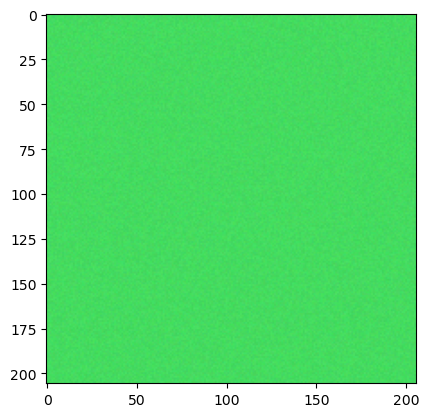

In [150]:
plt.imshow(preproces_img(max_out_activations(new_model1, 40, 0, (1, 256, 256, 3), 10)))

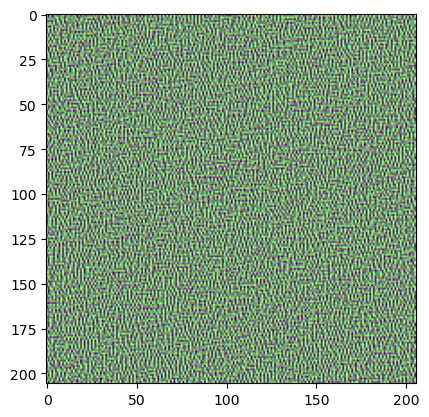

In [151]:
plt.imshow(preproces_img(max_out_activations(new_model1, 40, 1, (1, 256, 256, 3), 10)))

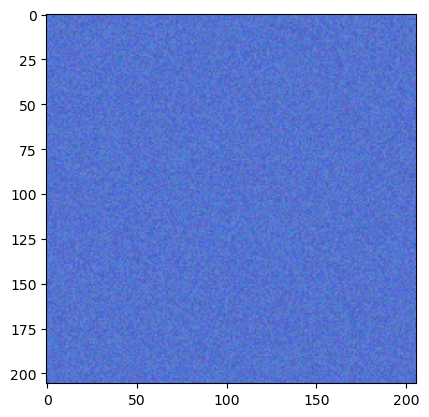

In [152]:
plt.imshow(preproces_img(max_out_activations(new_model1, 40, 2, (1, 256, 256, 3), 10)))

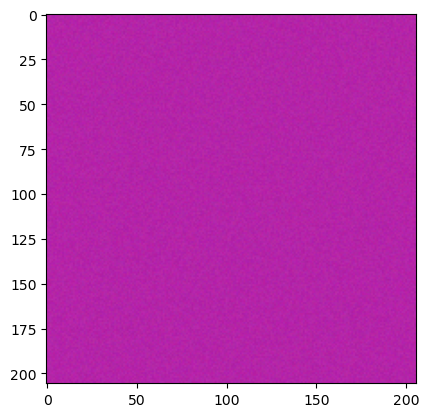

In [153]:
plt.imshow(preproces_img(max_out_activations(new_model1, 40, 3, (1, 256, 256, 3), 10)))

# We can print all the filters now!

In [154]:
models = [model1, model2, model3]

def get_convs_layers(model):
    outputs=[]
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D)):
            layer.trainable=False
            outputs.append(layer)
    return outputs

In [155]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 1st_conv_3x3 (Conv2D)       (None, 254, 254, 4)       112       
                                                                 
 1st_max_pooling (MaxPooling  (None, 127, 127, 4)      0         
 2D)                                                             
                                                                 
 2nd_conv_3x3 (Conv2D)       (None, 125, 125, 8)       296       
                                                                 
 features_vector (GlobalMaxP  (None, 8)                0         
 ooling2D)                                                       
                                                                 
 sigmoid_output (Dense)      (None, 1)                 9     

In [161]:
def image_per_filter_layer(models):
    images_dict = dict()

    for index, model in tqdm(enumerate(models), total=len(models)):    
        layers=get_convs_layers(model)
        w = model.input.shape[1]
        h = model.input.shape[2]
        c = model.input.shape[3]

        print(f"model_{index+1}")
        for layer in tqdm(layers, total=len(layers)):

            new_model = tf.keras.Model(inputs=model.input, outputs=layer.output, name=f"model_{index+1}")
            number_of_filters = layer.output.shape[-1]

            images_dict[f"{new_model.name}_{layer.name}"] = [max_out_activations(new_model=new_model, epochs=30, filter_index=filter_index, input_shape_size=(1, h, w, c), learning_rate=10) for filter_index in range(number_of_filters)]
        
    return images_dict

In [162]:
images_dict = image_per_filter_layer([model3])

  0%|          | 0/1 [00:00<?, ?it/s]

model_1


100%|██████████| 1/1 [02:50<00:00, 170.25s/it]


In [163]:
import math

In [165]:
images_dict.keys()

dict_keys(['model_1_1st_set_1st_conv_3x3', 'model_1_1st_set_2nd_conv_3x3', 'model_1_1st_set_3rd_conv_3x3', 'model_1_2nd_set_1st_conv_3x3', 'model_1_2nd_set_2nd_conv_3x3', 'model_1_2nd_set_3rd_conv_3x3', 'model_1_3rd_set_1st_conv_3x3', 'model_1_3rd_set_2nd_conv_3x3', 'model_1_3rd_set_3rd_conv_3x3', 'model_1_4th_set_1st_conv_3x3', 'model_1_4th_set_2nd_conv_3x3', 'model_1_4th_set_3rd_conv_3x3', 'model_1_5th_set_1st_conv_3x3', 'model_1_5th_set_2nd_conv_3x3', 'model_1_5th_set_3rd_conv_3x3'])

In [166]:
len(images_dict["model_1_5th_set_3rd_conv_3x3"])

64

In [167]:
np.all(images_dict["model_1_5th_set_3rd_conv_3x3"][0] == images_dict["model_1_5th_set_3rd_conv_3x3"][10])

True

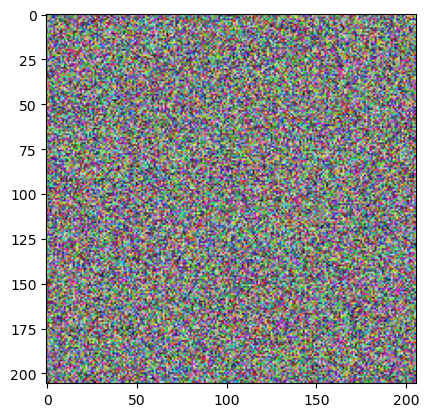

In [160]:
plt.imshow(preproces_img(images_dict["model_3_5th_set_2nd_conv_3x3"][1]))

In [ ]:
def print_filters(images_dict):
    for layer_name, generated_image_from_filters in images_dict.items():
        # print(layer_name)
        
        margin = 5
        all_images = [preproces_img(image) for image in generated_image_from_filters]

        c = 4
        r = math.ceil(len(all_images)/c)

        print(c, r)

        cropped_width = 256-25*2
        cropped_height = 256-25*2

        width = r * cropped_width + (r-1) * margin
        height = c * cropped_height + (c-1) * margin

        stitched_filters = np.zeros((width, height, 3))

        print(width, height)

        #rows
        for i in tqdm(range(r)):
            for j in range(c):
                # print(i*c+j)
                image = all_images[i * c +j]

                row_start= (cropped_width + margin) * i
                row_end = (cropped_height + margin) * i + cropped_width
                column_start = (cropped_height + margin) * j
                column_end = (cropped_height + margin) * j + cropped_height

                # print("row_start, row_end, column_start, column_end")
                # print(row_start, row_end, column_start, column_end)

                stitched_filters[row_start: row_end, column_start: column_end, :] = image

        tf.keras.utils.save_img(f"./part2-filters/{layer_name}.png", stitched_filters)

In [ ]:
print_filters(images_dict=images_dict)

# Debug

# It needs all the previous ones up to the last layer 5th_set_3rd_conv_3x3


Why I get no filter pattern print on this layer??

In [ ]:
sample_layer = model3.get_layer("5th_set_3rd_conv_3x3")
new_model3 = tf.keras.Model(inputs=model3.input, outputs=sample_layer.output)

new_model3.summary()

In [ ]:
sample_layer.get_config()

In [ ]:
sample_layer_weights = sample_layer.get_weights()

In [ ]:
sample_layer_kernel = sample_layer_weights[0]
sample_layer_bias = sample_layer_weights[1]

In [ ]:
sample_layer_kernel.shape

In [ ]:
# 64 filters of a set of 64

sample_layer_kernel[:, :, 0, :].shape

In [ ]:
#in total parameters

3*3*64*64+64 

In [ ]:
# plot one kernel
def preprocess_kernel_to_print(kernel):
    kernel_image = kernel.copy()

    kernel_image -= kernel_image.mean()
    kernel_image /= kernel_image.std()

    kernel_image*=64
    kernel_image+=128

    return np.clip(kernel_image, 0, 255).astype("uint8")

channel_index=0
filter_index=0

plt.imshow(preprocess_kernel_to_print(sample_layer_kernel[:, :, channel_index, filter_index]))
print(sample_layer_kernel[:, :, channel_index, filter_index])

# plot 1 kernel from each layer from the first to the last

In [ ]:
for layer in get_convs_layers(model3):
    print(layer.name)
    kernel = layer.get_weights()[0]
    print(kernel[:, :, 0, 0].shape)
    print(kernel[:, :, 0, 0])

In [ ]:
image = max_out_activations(model=new_model3, epochs=1, filter_index=0, input_shape_size=(1, 256, 256, 3), learning_rate=10)

In [ ]:
plt.imshow(preproces_img(image))

In [116]:
def print_filters(layer_name, all_images):       
    margin = 5
    # all_images = [preproces_img(image) for image in generated_image_from_filters]

    print(len(all_images))

    c = 4
    r = math.ceil(len(all_images)/c)

    print(c, r)

    cropped_width = 256-25*2
    cropped_height = 256-25*2

    width = r * cropped_width + (r-1) * margin
    height = c * cropped_height + (c-1) * margin

    stitched_filters = np.zeros((width, height, 3))

    print(width, height)

    #rows
    for i in tqdm(range(r)):
        for j in range(c):
            # print(i*c+j)
            image = all_images[i * c +j]

            row_start= (cropped_width + margin) * i
            row_end = (cropped_height + margin) * i + cropped_width
            column_start = (cropped_height + margin) * j
            column_end = (cropped_height + margin) * j + cropped_height

            # print("row_start, row_end, column_start, column_end")
            # print(row_start, row_end, column_start, column_end)

            stitched_filters[row_start: row_end, column_start: column_end, :] = image

    tf.keras.utils.save_img(f"./part2-filters/{layer_name}.png", stitched_filters)

In [117]:
sample_layer = model3.get_layer("5th_set_3rd_conv_3x3")
# sample_layer = model3.get_layer("5th_set_1st_conv_3x3")
# sample_layer = model3.get_layer("5th_set_2nd_conv_3x3")

new_model3 = tf.keras.Model(inputs=model3.input, outputs=sample_layer.output)

noise_image = tf.random.uniform(minval=0.4, maxval=0.6, shape=(1, 256, 256, 3))
lr=10
filter_index = 0

images = []
for filter_index in range(64):
    for epoch in range(30):
        with tf.GradientTape() as tape:
            tape.watch(noise_image)
            activation = new_model3(noise_image)
            activation = activation[:, :, :, filter_index]
            loss_value = loss(activation)

        # print(loss_value)
        # if loss_value == 0:
        #     print("NO activation")
        #     print(sample_layer.name)
        #     print(f"filter index: {filter_index}")
        #     print(sample_layer.get_weights()[0][:, :, 0, filter_index])
        #     # print(activation)
        #     break
        # if loss_value != 0:
        #     print("WITH activation")
        #     print(sample_layer.name)
        #     print(f"filter index: {filter_index}")
            # print(sample_layer.get_weights()[0][:, :, 0, filter_index])
            # print(activation)
            # plt.imshow(preproces_img(noise_image.numpy()[0]))
            # plt.show()
            # break

        gradients = tape.gradient(loss_value, noise_image)

        # print(gradients)
        gradients = tf.math.l2_normalize(gradients)
        # print(gradients)

        noise_image += gradients*lr

        # plt.imshow(preproces_img(noise_image.numpy()[0]))
        # plt.show()
    if loss_value != 0:
        print("WITH activation")
        print(sample_layer.name)
        print(f"filter index: {filter_index}")
        # plt.imshow(preproces_img(noise_image.numpy()[0]))
        # plt.show()
    
    images.append(preproces_img(noise_image.numpy()[0].copy()))

WITH activation
5th_set_3rd_conv_3x3
filter index: 1
WITH activation
5th_set_3rd_conv_3x3
filter index: 2
WITH activation
5th_set_3rd_conv_3x3
filter index: 4
WITH activation
5th_set_3rd_conv_3x3
filter index: 5
WITH activation
5th_set_3rd_conv_3x3
filter index: 6
WITH activation
5th_set_3rd_conv_3x3
filter index: 7
WITH activation
5th_set_3rd_conv_3x3
filter index: 10
WITH activation
5th_set_3rd_conv_3x3
filter index: 13
WITH activation
5th_set_3rd_conv_3x3
filter index: 14
WITH activation
5th_set_3rd_conv_3x3
filter index: 16
WITH activation
5th_set_3rd_conv_3x3
filter index: 21
WITH activation
5th_set_3rd_conv_3x3
filter index: 22
WITH activation
5th_set_3rd_conv_3x3
filter index: 23
WITH activation
5th_set_3rd_conv_3x3
filter index: 26
WITH activation
5th_set_3rd_conv_3x3
filter index: 27
WITH activation
5th_set_3rd_conv_3x3
filter index: 29
WITH activation
5th_set_3rd_conv_3x3
filter index: 30
WITH activation
5th_set_3rd_conv_3x3
filter index: 31
WITH activation
5th_set_3rd_conv_3

In [118]:
len(images)

64

In [121]:
sample_layer.name

'5th_set_3rd_conv_3x3'

In [120]:
print_filters(sample_layer.name, images)

64
4 16
3371 839


100%|██████████| 16/16 [00:00<00:00, 1849.49it/s]
